# Examen Primer parcial

El modelo debe permitir capturar los datos de las actas de conteo de votos correspondientes a la elección para presidente en el presente año.
Se debe lograr capturar la siguiente información: número de mesa, numero de votos por partido, blancos y nulos.
Los datos que se capturen deben ser almacenados en una base de datos, de acuerdo a una estructura que cada estudiante vea por conveniente.

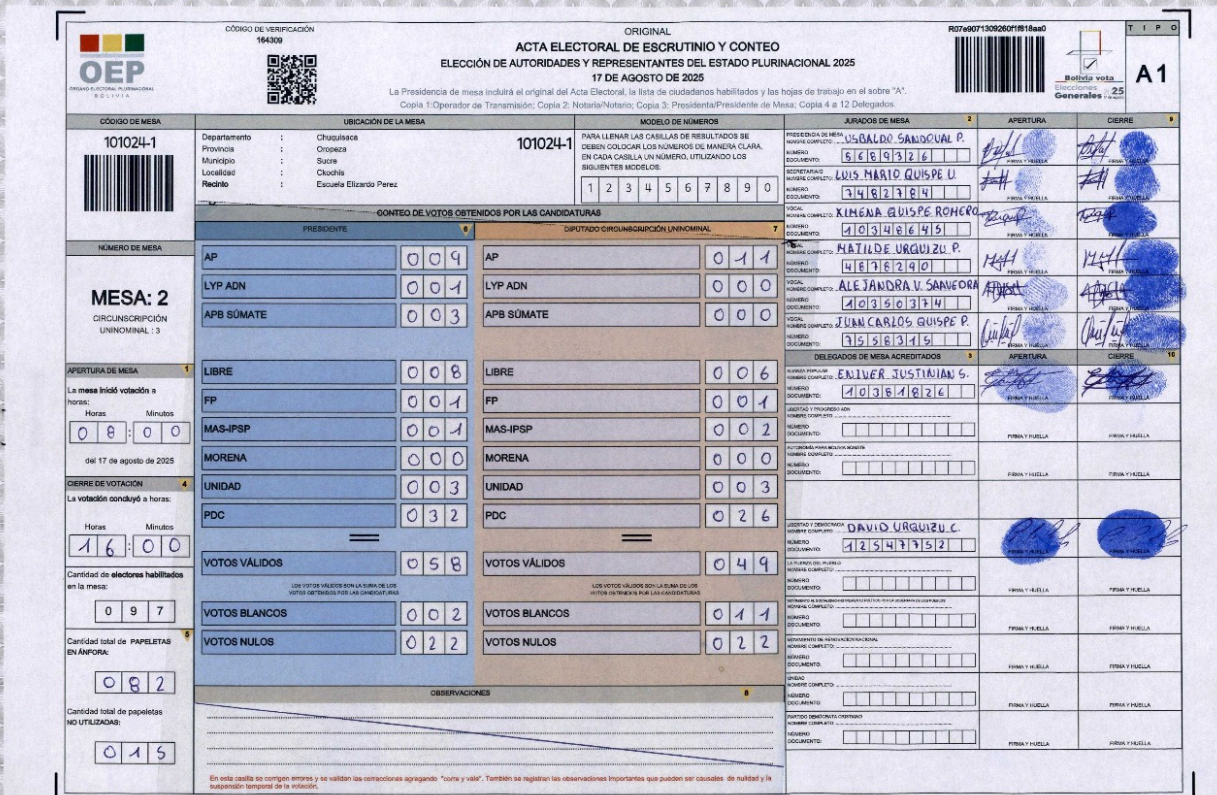

In [1]:
from google.colab import drive

# Montar el drive
drive.mount('/content/drive')


Mounted at /content/drive


# RECORTE DE MESA

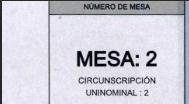

In [ ]:
import cv2
import numpy as np
from pathlib import Path
import glob

def recortar_mesa_desde_acta(img_path, out_path,
                              roi=(0.04, 0.30, 0.15, 0.12)):
    """
    Recorta la sección de 'MESA' desde la acta completa usando un ROI relativo.
    roi = (fx, fy, fw, fh) fracciones respecto al ancho/alto.
    """
    img = cv2.imread(str(img_path))
    if img is None:
        raise RuntimeError(f"No se pudo leer {img_path}")

    H, W = img.shape[:2]
    fx, fy, fw, fh = roi

    x = int(fx * W)
    y = int(fy * H)
    w = int(fw * W)
    h = int(fh * H)

    recorte = img[y:y+h, x:x+w]
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)  # asegura carpeta
    cv2.imwrite(str(out_path), recorte)
    return str(out_path)


In [ ]:
BASE_DIR = Path("/content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial")
ACTAS_DIR = BASE_DIR / "actas"                # aquí están acta_1.jpg, acta_2.jpg, ...
OUT_DIR   = BASE_DIR / "recorte_actas"        # aquí crearemos acta_1/, acta_2/, ...
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("ACTAS_DIR:", ACTAS_DIR)
print("OUT_DIR  :", OUT_DIR)


ACTAS_DIR: /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/actas
OUT_DIR  : /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/recorte_actas


In [ ]:
# ejemplo puntual con acta_4.jpg
ACTA = ACTAS_DIR / "acta_4.jpg"
DESTINO = OUT_DIR /"acta_4"/"mesa.png"   # tú eliges el índice/carpeta

ruta = recortar_mesa_desde_acta(
    ACTA, DESTINO,
    roi=(0.04, 0.30, 0.15, 0.12)            # más abajo; ajusta si necesitas
)
print("Recorte MESA guardado en:", ruta)


Recorte MESA guardado en: /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/recorte_actas/acta_4/mesa.png


# Recorte de votos presidenciales
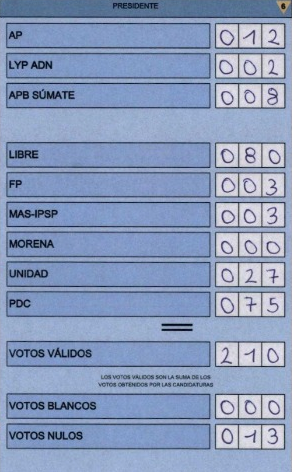

In [ ]:
import cv2
import numpy as np
from pathlib import Path

def recortar_panel_presidente_desde_acta(img_path, out_path,
                                         lower_hsv=(90,50,95), upper_hsv=(125,255,255),
                                         left_ratio=0.30,
                                         expand_px=4):
    """
    Recorta solo la sección celeste de 'PRESIDENTE' desde la acta completa.
    Guarda la imagen en out_path.
    """
    img = cv2.imread(str(img_path))
    if img is None:
        raise RuntimeError(f"No puedo leer {img_path}")

    H, W = img.shape[:2]
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # detectar azul del bloque PRESIDENTE
    lower = np.array(lower_hsv)
    upper = np.array(upper_hsv)
    mask = cv2.inRange(hsv, lower, upper)

    # Limpiar y quedarnos con la parte izquierda
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE,
                            cv2.getStructuringElement(cv2.MORPH_RECT,(7,7)), iterations=2)
    mask[:, int(W*left_ratio):] = 0

    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        raise RuntimeError("No se encontró el bloque PRESIDENTE.")

    x,y,w,h = max([cv2.boundingRect(c) for c in cnts], key=lambda r:r[2]*r[3])
    # margen extra
    x = max(0, x-expand_px); y = max(0, y-expand_px)
    w = min(W-x, w+2*expand_px); h = min(H-y, h+2*expand_px)

    recorte = img[y:y+h, x:x+w]

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)  # <- crea recorte_actas/acta_1/
    cv2.imwrite(str(out_path), recorte)
    return str(out_path)


In [ ]:
BASE_DIR = Path("/content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial")

ACTA = BASE_DIR / "actas" / "acta_4.jpg"  # tu imagen completa
OUT  = BASE_DIR / "recorte_actas" / "acta_4" / "panel_presidente.png"

ruta = recortar_panel_presidente_desde_acta(
    ACTA, OUT,
    left_ratio=0.75,  # más a la izquierda si lo subes
    expand_px=0       # recorte más pequeño
)
print("Panel PRESIDENTE recortado en:", ruta)


Panel PRESIDENTE recortado en: /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/recorte_actas/acta_4/panel_presidente.png


# Recorte por Partidos y votos validos, nulo y blancos

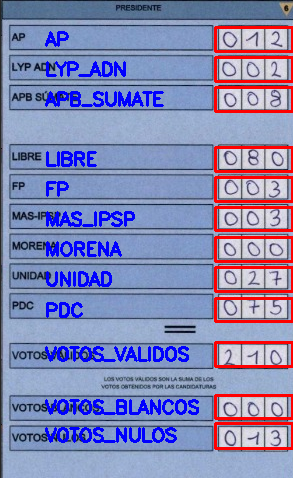

In [ ]:
import cv2
from pathlib import Path

def preview_y_guardar_votos_por_roi(img_path, out_dir, debug=True,
                                    grow_x=0.00, grow_y=0.00):
    """
    Dibuja el preview y GUARDA cada recorte con su nombre.
    grow_x/grow_y: margen extra relativo (0.03 = +3% en ancho, 0.06 = +6% en alto).
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    img = cv2.imread(str(img_path))
    if img is None:
        raise RuntimeError(f"No puedo leer {img_path}")
    H, W = img.shape[:2]

    etiquetas = [
        "AP", "LYP_ADN", "APB_SUMATE",
        "LIBRE", "FP", "MAS_IPSP",
        "MORENA", "UNIDAD", "PDC",
        "VOTOS_VALIDOS", "VOTOS_BLANCOS", "VOTOS_NULOS"
    ]

    filas_y = [
        (0.0604, 0.1068),  # AP
        (0.1229, 0.1689),  # LYP_ADN
        (0.1854, 0.2291),  # APB_SUMATE

        (0.3083, 0.3534),  # LIBRE
        (0.3708, 0.4155),  # FP
        (0.4313, 0.4757),  # MAS_IPSP
        (0.4938, 0.5398),  # MORENA
        (0.5563, 0.6000),  # UNIDAD
        (0.6188, 0.6621),  # PDC

        (0.7100, 0.7560),  # VOTOS_VALIDOS
        (0.8200, 0.8620),  # VOTOS_BLANCOS
        (0.8780, 0.9240),  # VOTOS_NULOS
    ]

    # Banda derecha de los dígitos
    x_start_ratio = 0.735
    x_end_ratio   = 0.985

    vis = img.copy()
    rutas = []

    x0b = int(W * x_start_ratio)
    x1b = int(W * x_end_ratio)

    for i, (etiqueta, (y0r, y1r)) in enumerate(zip(etiquetas, filas_y), start=1):
        x0 = x0b
        x1 = x1b
        y0 = int(H * y0r)
        y1 = int(H * y1r)

        # Margen opcional para que el recorte salga un poco más grande
        if grow_x or grow_y:
            w = x1 - x0
            h = y1 - y0
            dx = int(w * grow_x)
            dy = int(h * grow_y)
            x0 = max(0, x0 - dx); x1 = min(W, x1 + dx)
            y0 = max(0, y0 - dy); y1 = min(H, y1 + dy)

        # Preview
        cv2.rectangle(vis, (x0, y0), (x1, y1), (0, 0, 255), 2)
        cv2.putText(vis, etiqueta, (max(5, x0-170), y0+18),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        # Recorte y guardado con nombre
        recorte = img[y0:y1, x0:x1]
        out_file = out_dir / f"{i:02d}_{etiqueta}.png"
        cv2.imwrite(str(out_file), recorte)
        rutas.append(str(out_file))

    if debug:
        out_file = out_dir / "_preview.png"
        cv2.imwrite(str(out_file), vis)
        print(f"Preview guardado en: {out_file}")

    return rutas


# ================== EJEMPLO DE USO ==================
BASE_DIR = Path("/content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial")
PANEL = BASE_DIR / "recorte_actas" / "acta_4" / "panel_presidente.png"
SALIDA = BASE_DIR / "recorte_actas" / "acta_4" / "votos_por_partidos"

rutas = preview_y_guardar_votos_por_roi(
    PANEL, SALIDA, debug=True,
    grow_x=0.03,  # <-- +3% de ancho (ajusta si quieres)
    grow_y=0.06   # <-- +6% de alto
)

print("Recortes guardados:")
for r in rutas:
    print(" -", r)


Preview guardado en: /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/recorte_actas/acta_4/votos_por_partidos/_preview.png
Recortes guardados:
 - /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/recorte_actas/acta_4/votos_por_partidos/01_AP.png
 - /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/recorte_actas/acta_4/votos_por_partidos/02_LYP_ADN.png
 - /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/recorte_actas/acta_4/votos_por_partidos/03_APB_SUMATE.png
 - /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/recorte_actas/acta_4/votos_por_partidos/04_LIBRE.png
 - /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/recorte_actas/acta_4/votos_por_partidos/05_FP.png
 - /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/recorte_actas/acta_4/votos_por_partidos/06_MAS_IPSP.png
 - /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/recorte_actas/acta_4/votos_por_partidos/07_MORENA.p

# Red convolucional SqueezeNet(2016)

In [4]:
# ===================== SqueezeNet + SVHN + Template Acta (simple y funcional) =====================
# Reqs: pip install torch torchvision opencv-python scipy

import os, csv, time, glob
from pathlib import Path
import numpy as np
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

# -------------------- RUTAS Y CONFIG --------------------
ROOT       = Path.cwd()
MODELS_DIR = ROOT / "models"; MODELS_DIR.mkdir(exist_ok=True)
DATA_DIR   = ROOT / "data";   DATA_DIR.mkdir(exist_ok=True)
OUT_DIR    = ROOT / "out";    OUT_DIR.mkdir(exist_ok=True)
WEIGHTS    = MODELS_DIR / "squeezenet_svhn.pth"

# Cambia esta ruta a tu imagen:
ACTA_IMG = r"/content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/actas"

# Columnas de salida
LABELS_VOTOS = [
    "AP", "LYP_ADN", "APB_SUMATE",
    "LIBRE", "FP", "MAS_IPSP",
    "MORENA", "UNIDAD", "PDC",
    "VOTOS_VALIDOS", "VOTOS_BLANCOS", "VOTOS_NULOS"
]

# Performance
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 0  # pon 2 en Linux para acelerar
PIN_MEMORY  = torch.cuda.is_available()
torch.backends.cudnn.benchmark = True
print("Device:", DEVICE)

# -------------------- TRANSFORMS A TENSOR --------------------
to_tensor = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

def to_3ch_pil(arr):
    if arr.ndim == 2:
        arr = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)
    else:
        arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
    return Image.fromarray(arr)

# -------------------- PREPROCESADO DE CADA RECORTE (CLAVE) --------------------
def preprocess_crop_for_digit(bgr, tight=True):
    """ Quita borde, centra y deja el dígito negro sobre blanco. """
    if bgr is None or bgr.size == 0:
        return np.full((64,64,3), 255, np.uint8)
    if bgr.ndim==3:
        g = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    else:
        g = bgr.copy()

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    g = clahe.apply(g)
    g = cv2.GaussianBlur(g,(3,3),0)
    _, bw = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    bw2 = cv2.morphologyEx(bw, cv2.MORPH_OPEN,
                           cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)), 1)
    cnts,_ = cv2.findContours(bw2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        sq = cv2.copyMakeBorder(255-bw,10,10,10,10, cv2.BORDER_CONSTANT, value=255)
        return cv2.cvtColor(sq, cv2.COLOR_GRAY2BGR)

    x,y,w,h = cv2.boundingRect(max(cnts, key=cv2.contourArea))
    pad = max(2, int(0.12*max(w,h))) if tight else 6
    x0,y0 = max(0, x-pad), max(0, y-pad)
    x1,y1 = min(bw.shape[1], x+w+pad), min(bw.shape[0], y+h+pad)
    digit = bw[y0:y1, x0:x1]

    hh, ww = digit.shape[:2]
    side = max(hh, ww)
    t = (side-hh)//2; l = (side-ww)//2
    sq = cv2.copyMakeBorder(digit, t, side-hh-t, l, side-ww-l,
                            cv2.BORDER_CONSTANT, value=0)
    sq = 255 - sq
    return cv2.cvtColor(sq, cv2.COLOR_GRAY2BGR)

# -------------------- MODELO: SqueezeNet (10 clases) --------------------
def make_squeezenet_digit_model(pretrained=True):
    try:
        from torchvision.models import SqueezeNet1_1_Weights
        weights = SqueezeNet1_1_Weights.IMAGENET1K_V1 if pretrained else None
        model = torchvision.models.squeezenet1_1(weights=weights)
    except Exception:
        model = torchvision.models.squeezenet1_1(pretrained=pretrained)
    model.classifier[1] = nn.Conv2d(512, 10, kernel_size=1)
    model.num_classes = 10
    return model.to(DEVICE)

# -------------------- DATASET: SVHN (robusto) --------------------
# Nota: en SVHN el dígito '0' se etiqueta como 10 -> convertimos a 0
class SVHNDigits(Dataset):
    def __init__(self, split="train"):
        self.ds = torchvision.datasets.SVHN(root=str(DATA_DIR), split=split, download=True)
        aug = (split == "train")
        self.tf = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ColorJitter(brightness=0.15, contrast=0.15) if aug else transforms.Lambda(lambda x: x),
            transforms.RandomAffine(degrees=5, translate=(0.04,0.04), scale=(0.96,1.04)) if aug else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, i):
        img, y = self.ds[i]  # img puede ser PIL o np.ndarray HxWxC
        # normaliza a PIL
        if isinstance(img, np.ndarray):
            if img.ndim == 3 and img.shape[0] in (1,3,4) and img.shape[2] not in (1,3,4):
                img = np.transpose(img, (1,2,0))
            img = Image.fromarray(img)
        elif torch.is_tensor(img):
            img = Image.fromarray(img.permute(1,2,0).cpu().numpy())
        # si ya era PIL, se queda igual

        y = int(y);  y = 0 if y==10 else y
        return self.tf(img), y

# -------------------- ENTRENAR O CARGAR --------------------
def train_or_load(weights_path=WEIGHTS, epochs=6, batch=256, lr=2e-3,
                  freeze_backbone=True, train_subset=30000, val_subset=10000):
    model = make_squeezenet_digit_model(pretrained=True)

    if Path(weights_path).exists():
        model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
        model.eval()
        print(">> Pesos cargados:", weights_path)
        return model

    if freeze_backbone:
        for p in model.features.parameters():
            p.requires_grad = False

    print(">> Preparando SVHN...")
    tr = SVHNDigits(split="train")
    va = SVHNDigits(split="test")
    if train_subset and train_subset < len(tr):
        tr = Subset(tr, np.random.choice(len(tr), train_subset, replace=False))
    if val_subset and val_subset < len(va):
        va = Subset(va, np.random.choice(len(va), val_subset, replace=False))

    tr_dl = DataLoader(tr, batch_size=batch, shuffle=True,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    va_dl = DataLoader(va, batch_size=batch, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=lr, weight_decay=1e-4)
    crit = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    best = 0.0
    for ep in range(1, epochs+1):
        t0 = time.time()
        # ---- train ----
        model.train(); tot=cor=0; loss_sum=0.0
        for xb,yb in tr_dl:
            xb,yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                out = model(xb)
                logits = out.squeeze(-1).squeeze(-1) if out.ndim==4 else out
                loss = crit(logits, yb)
            scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
            loss_sum += float(loss)*xb.size(0)
            cor += (logits.argmax(1)==yb).sum().item(); tot += xb.size(0)

        # ---- val ----
        model.eval(); vtot=vcor=0
        with torch.no_grad():
            for xb,yb in va_dl:
                xb,yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
                out = model(xb)
                logits = out.squeeze(-1).squeeze(-1) if out.ndim==4 else out
                vcor += (logits.argmax(1)==yb).sum().item(); vtot += xb.size(0)
        tr_acc = cor/tot; val_acc = vcor/vtot
        print(f"[{ep}/{epochs}] {time.time()-t0:.1f}s  train_acc {tr_acc:.3f}  val_acc {val_acc:.3f}")

        if val_acc > best:
            best = val_acc
            torch.save(model.state_dict(), weights_path)

    model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    model.eval()
    print(">> Pesos guardados en:", weights_path, "| mejor val_acc:", f"{best:.3f}")
    return model

# -------------------- PREDICCIÓN: concatenar dígitos --------------------
@torch.inference_mode()
def predict_digits(model, crops_bgr):
    s=[]
    for crop in crops_bgr:
        proc = preprocess_crop_for_digit(crop, tight=True)
        x = to_tensor(to_3ch_pil(proc)).unsqueeze(0).to(DEVICE)
        out = model(x)
        logits = out.squeeze(-1).squeeze(-1) if out.ndim==4 else out
        d = int(torch.argmax(logits, dim=1).item())
        s.append(str(d))
    return "".join(s)

# -------------------- SEGMENTACIÓN GENÉRICA (para MESA multi-dígito) --------------------
def segment_digits_generic(img_bgr, max_digits=4):
    """ Intenta separar varios dígitos en un recorte (mesa). """
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g,(3,3),0)
    _, bw = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    ker = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, ker, 1)
    cnts,_ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes=[]
    H,W = bw.shape[:2]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if w*h < 60: continue
        if h < 0.25*H: continue
        boxes.append((x,y,w,h))
    if not boxes:
        return []
    boxes = sorted(boxes, key=lambda b: b[0])[:max_digits]
    crops=[]
    for (x,y,w,h) in boxes:
        pad = max(2, int(0.1*max(w,h)))
        x0, y0 = max(0, x-pad), max(0, y-pad)
        x1, y1 = min(W, x+w+pad), min(H, y+h+pad)
        digit = img_bgr[y0:y1, x0:x1]
        hh, ww = digit.shape[:2]; side = max(hh, ww)
        t=(side-hh)//2; l=(side-ww)//2
        crops.append(cv2.copyMakeBorder(digit,t,side-hh-t,l,side-ww-l,cv2.BORDER_CONSTANT,value=(255,255,255)))
    return crops

# -------------------- TEMPLATE (tus coordenadas relativas) --------------------
TEMPLATE = {
    "numero_mesa": {"x": 0.133, "y": 0.338, "w": 0.030, "h": 0.045},  # cuadro "MESA: 1"
    "filas": [
        {"nombre": "AP", "cells": [
            {"x": 0.332, "y": 0.305, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.305, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.305, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.305, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "LYP ADN", "cells": [
            {"x": 0.332, "y": 0.338, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.338, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.338, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.338, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "APB SUMATE", "cells": [
            {"x": 0.332, "y": 0.371, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.371, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.371, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.371, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "LIBRE", "cells": [
            {"x": 0.332, "y": 0.442, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.442, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.442, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.442, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "FP", "cells": [
            {"x": 0.332, "y": 0.477, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.477, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.477, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.477, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "MAS-IPSP", "cells": [
            {"x": 0.332, "y": 0.512, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.512, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.512, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.512, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "MORENA", "cells": [
            {"x": 0.332, "y": 0.547, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.547, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.547, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.547, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "UNIDAD", "cells": [
            {"x": 0.332, "y": 0.582, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.582, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.582, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.582, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "PDC", "cells": [
            {"x": 0.332, "y": 0.617, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.617, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.617, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.617, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "VOTOS VALIDOS", "cells": [
            {"x": 0.332, "y": 0.673, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.673, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.673, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.673, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "VOTOS BLANCOS", "cells": [
            {"x": 0.332, "y": 0.735, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.735, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.735, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.735, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "VOTOS NULOS", "cells": [
            {"x": 0.332, "y": 0.770, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.770, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.770, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.770, "w": 0.020, "h": 0.03}
             ]}
        ]}
    ]
}

# -------------------- OVERLAY PARA VERIFICAR PLANTILLA --------------------
def draw_overlay(image_bgr, cfg, save_path=None):
    vis = image_bgr.copy()
    H, W = vis.shape[:2]

    m = cfg["numero_mesa"]
    cv2.rectangle(vis,
                  (int(m["x"]*W), int(m["y"]*H)),
                  (int((m["x"]+m["w"])*W), int((m["y"]+m["h"])*H)),
                  (255,0,0), 2)

    for fila in cfg["filas"]:
        for c in fila["cells"]:
            cv2.rectangle(vis,
                          (int(c["x"]*W), int(c["y"]*H)),
                          (int((c["x"]+c["w"])*W), int((c["y"]+c["h"])*H)),
                          (0,0,255), 2)
            cv2.putText(vis, fila["nombre"],
                        (int(c["x"]*W), int(c["y"]*H)-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
            for idx, slot in enumerate(c.get("slots", []), 1):
                cv2.rectangle(vis,
                              (int(slot["x"]*W), int(slot["y"]*H)),
                              (int((slot["x"]+slot["w"])*W), int((slot["y"]+slot["h"])*H)),
                              (0,128,255), 2)
                cv2.putText(vis, f"S{idx}",
                            (int(slot["x"]*W), int(slot["y"]*H)-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,128,255), 1)
    if save_path:
        cv2.imwrite(str(save_path), vis)
    return vis

# -------------------- RATIO -> PIXELES Y CROP --------------------
def _clip(v, lo, hi): return max(lo, min(int(v), hi))

def ratio_to_xyxy(box, W, H, pad_ratio=0.0, dxr=0.0, dyr=0.0, sx=1.0, sy=1.0):
    x, y, w, h = box["x"], box["y"], box["w"], box["h"]
    x = (x + dxr) * sx
    y = (y + dyr) * sy
    w = w * sx
    h = h * sy
    x_pad = w * pad_ratio; y_pad = h * pad_ratio
    x0 = (x - x_pad) * W; y0 = (y - y_pad) * H
    x1 = (x + w + x_pad) * W; y1 = (y + h + y_pad) * H
    x0 = _clip(x0, 0, W-1); y0 = _clip(y0, 0, H-1)
    x1 = _clip(x1, 1, W);   y1 = _clip(y1, 1, H)
    if x1 <= x0: x1 = min(W, x0+2)
    if y1 <= y0: y1 = min(H, y0+2)
    return int(x0), int(y0), int(x1), int(y1)

def crop_ratio(img_bgr, box, pad_ratio=0.0, dxr=0.0, dyr=0.0, sx=1.0, sy=1.0):
    H, W = img_bgr.shape[:2]
    x0, y0, x1, y1 = ratio_to_xyxy(box, W, H, pad_ratio, dxr, dyr, sx, sy)
    return img_bgr[y0:y1, x0:x1].copy()

# -------------------- NORMALIZAR NOMBRES PARA CSV --------------------
def norm_name(name):
    name = name.strip().upper().replace("-", "_").replace(" ", "_")
    if name in ("MAS_IPSP","MAS-IPSP"): name = "MAS_IPSP"
    if name in ("LYP_ADN","LYP__ADN"): name = "LYP_ADN"
    return name

# -------------------- EXTRACCIÓN + PREDICCIÓN DESDE TEMPLATE --------------------
def extract_and_predict_from_template(img_bgr, template, model,
                                      pad_ratio=0.02, dxr=0.0, dyr=0.0, sx=1.0, sy=1.0):
    """ Devuelve dict con mesa y cada partido -> 3 dígitos """
    out = {}

    # MESA (puede ser multi-dígito)
    mesa_box = template["numero_mesa"]
    mesa_crop = crop_ratio(img_bgr, mesa_box, pad_ratio, dxr, dyr, sx, sy)
    mesa_digits = segment_digits_generic(mesa_crop, max_digits=4)
    if mesa_digits:
        out["mesa"] = predict_digits(model, mesa_digits)
    else:
        out["mesa"] = predict_digits(model, [mesa_crop])

    # Filas (3 slots cada una)
    for fila in template["filas"]:
        nombre = norm_name(fila["nombre"])
        c = fila["cells"][0]
        slots = c.get("slots", [])
        slot_crops = []
        for slot in slots:
            # entramos un poco más para evitar bordes de la caja
            crop = crop_ratio(img_bgr, slot, pad_ratio=0.04, dxr=dxr, dyr=dyr, sx=sx, sy=sy)
            slot_crops.append(crop)
        pred = predict_digits(model, slot_crops) if slot_crops else "000"
        out[nombre] = pred.rjust(3, "0")[:3]

    return out

# -------------------- CSV --------------------
def write_csv_from_preds(preds, out_csv_path):
    cols = ["mesa"] + LABELS_VOTOS
    row = {k: preds.get(k, "") for k in cols}
    with open(out_csv_path, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=cols)
        w.writeheader(); w.writerow(row)
    print("CSV:", out_csv_path)

# -------------------- MAIN --------------------
# -------------------- MAIN (procesar carpeta completa) --------------------
if __name__ == "__main__":
    # 0) Rutas
    ACTAS_DIR = Path("/content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/actas")
    OUT_DIR.mkdir(exist_ok=True)
    OVERLAYS_DIR = OUT_DIR / "overlays"; OVERLAYS_DIR.mkdir(exist_ok=True)

    # 1) Cargar/entrenar SqueezeNet (si ya hay pesos, se cargan)
    model = train_or_load(
        epochs=6, batch=256, lr=2e-3,
        freeze_backbone=True, train_subset=30000, val_subset=10000
    )

    # 2) Buscar imágenes en la carpeta de actas
    files = sorted(
        list(ACTAS_DIR.glob("*.png")) +
        list(ACTAS_DIR.glob("*.jpg")) +
        list(ACTAS_DIR.glob("*.jpeg"))
    )
    if not files:
        raise RuntimeError(f"No encontré imágenes en: {ACTAS_DIR}")

    # 3) Preparar CSV (una fila por acta)
    cols = ["acta_file", "mesa"] + LABELS_VOTOS
    csv_rows = [cols]

    # 4) Procesar cada acta
    for p in files:
        img_bgr = cv2.imread(str(p))
        if img_bgr is None:
            print(f"[WARN] No pude leer {p}, salto.")
            continue

        # 4a) Overlay para verificar alineación del TEMPLATE
        overlay_path = OVERLAYS_DIR / f"{p.stem}_overlay.png"
        _ = draw_overlay(img_bgr, TEMPLATE, save_path=overlay_path)

        # 4b) Extraer y predecir con el TEMPLATE
        preds = extract_and_predict_from_template(
            img_bgr, TEMPLATE, model,
            pad_ratio=0.02, dxr=0.0, dyr=0.0, sx=1.0, sy=1.0
        )

        # 4c) Agregar fila al CSV
        row = [p.name, preds.get("mesa", "")]
        for k in LABELS_VOTOS:
            row.append(preds.get(k, ""))
        csv_rows.append(row)

        print(f"OK: {p.name} -> mesa={preds.get('mesa','')}")

    # 5) Guardar CSV con todo
    out_csv = OUT_DIR / "resultados_actas_template.csv"
    import csv
    with open(out_csv, "w", newline="", encoding="utf-8") as f:
        csv.writer(f).writerows(csv_rows)
    print("CSV guardado en:", out_csv)
    print("Overlays en:", OVERLAYS_DIR)


# ===================== fin =====================


Device: cuda
>> Pesos cargados: /content/models/squeezenet_svhn.pth
OK: acta_1.jpg -> mesa=33
OK: acta_2.jpg -> mesa=3
OK: acta_3.jpg -> mesa=4
OK: acta_4.jpg -> mesa=3
CSV guardado en: /content/out/resultados_actas_template.csv
Overlays en: /content/out/overlays


In [8]:
# ===================== SqueezeNet + SVHN + TEMPLATE (MESA + VOTOS) =====================
# Reqs: pip install torch torchvision opencv-python

import os, csv, time
from pathlib import Path
import numpy as np
import cv2
from PIL import Image
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms
import random

# -------------------- RUTAS Y CONFIG --------------------
# Ajusta estas 3 rutas a tu gusto:
MODELS_DIR = Path("/content/models"); MODELS_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR   = Path("/content/data");   DATA_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR    = Path("/content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial");    OUT_DIR.mkdir(parents=True, exist_ok=True)
WEIGHTS    = MODELS_DIR / "squeezenet_svhn.pth"

# Carpeta con las actas:
ACTAS_DIR  = Path("/content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/actas")

# Columnas CSV
LABELS_VOTOS = [
    "AP", "LYP_ADN", "APB_SUMATE",
    "LIBRE", "FP", "MAS_IPSP",
    "MORENA", "UNIDAD", "PDC",
    "VOTOS_VALIDOS", "VOTOS_BLANCOS", "VOTOS_NULOS"
]

# Rendimiento
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 0  # pon 2 en Linux para acelerar
PIN_MEMORY  = torch.cuda.is_available()
torch.backends.cudnn.benchmark = True
print("Device:", DEVICE)

# Semillas (reproducibilidad ligera)
random.seed(123); np.random.seed(123); torch.manual_seed(123)

# -------------------- TRANSFORMS A TENSOR --------------------
to_tensor = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
def to_3ch_pil(arr):
    if arr.ndim == 2:
        arr = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)
    else:
        arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
    return Image.fromarray(arr)

# -------------------- PREPROCESADO DE CADA RECORTE (CLAVE) --------------------
def preprocess_crop_for_digit(bgr, tight=True):
    """ Quita borde, centra y deja el dígito negro sobre blanco. """
    if bgr is None or bgr.size == 0:
        return np.full((64,64,3), 255, np.uint8)
    if bgr.ndim==3:
        g = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    else:
        g = bgr.copy()
    # contraste + suavizado + binarización
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    g = clahe.apply(g)
    g = cv2.GaussianBlur(g,(3,3),0)
    _, bw = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # limpiar ruido
    bw2 = cv2.morphologyEx(
        bw, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)), 1
    )
    cnts,_ = cv2.findContours(bw2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        sq = cv2.copyMakeBorder(255-bw,10,10,10,10, cv2.BORDER_CONSTANT, value=255)
        return cv2.cvtColor(sq, cv2.COLOR_GRAY2BGR)

    x,y,w,h = cv2.boundingRect(max(cnts, key=cv2.contourArea))
    pad = max(2, int(0.12*max(w,h))) if tight else 6
    x0,y0 = max(0, x-pad), max(0, y-pad)
    x1,y1 = min(bw.shape[1], x+w+pad), min(bw.shape[0], y+h+pad)
    digit = bw[y0:y1, x0:x1]
    # cuadrar
    hh, ww = digit.shape[:2]
    side = max(hh, ww)
    t = (side-hh)//2; l = (side-ww)//2
    sq = cv2.copyMakeBorder(digit, t, side-hh-t, l, side-ww-l,
                            cv2.BORDER_CONSTANT, value=0)
    sq = 255 - sq
    return cv2.cvtColor(sq, cv2.COLOR_GRAY2BGR)

# -------------------- MODELO: SqueezeNet (10 clases) --------------------
def make_squeezenet_digit_model(pretrained=True):
    try:
        from torchvision.models import SqueezeNet1_1_Weights
        weights = SqueezeNet1_1_Weights.IMAGENET1K_V1 if pretrained else None
        model = torchvision.models.squeezenet1_1(weights=weights)
    except Exception:
        model = torchvision.models.squeezenet1_1(pretrained=pretrained)
    model.classifier[1] = nn.Conv2d(512, 10, kernel_size=1)  # 10 dígitos
    model.num_classes = 10
    return model.to(DEVICE)

# -------------------- DATASET: SVHN (robusto) --------------------
# Nota: SVHN etiqueta '0' como 10 -> lo convertimos a 0.
class SVHNDigits(Dataset):
    def __init__(self, split="train"):
        self.ds = torchvision.datasets.SVHN(root=str(DATA_DIR), split=split, download=True)
        aug = (split == "train")
        self.tf = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ColorJitter(brightness=0.15, contrast=0.15) if aug else transforms.Lambda(lambda x: x),
            transforms.RandomAffine(degrees=5, translate=(0.04,0.04), scale=(0.96,1.04)) if aug else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        img, y = self.ds[i]  # img puede ser PIL o np.ndarray
        # normaliza a PIL
        if isinstance(img, np.ndarray):
            if img.ndim == 3 and img.shape[0] in (1,3,4) and img.shape[2] not in (1,3,4):
                img = np.transpose(img, (1,2,0))
            img = Image.fromarray(img)
        elif torch.is_tensor(img):
            img = Image.fromarray(img.permute(1,2,0).cpu().numpy())
        y = int(y);  y = 0 if y==10 else y
        return self.tf(img), y

# -------------------- ENTRENAR O CARGAR --------------------
def train_or_load(weights_path=WEIGHTS, epochs=6, batch=256, lr=2e-3,
                  freeze_backbone=True, train_subset=30000, val_subset=10000):
    model = make_squeezenet_digit_model(pretrained=True)

    if Path(weights_path).exists():
        model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
        model.eval()
        print(">> Pesos cargados:", weights_path)
        return model

    if freeze_backbone:
        for p in model.features.parameters():
            p.requires_grad = False

    print(">> Preparando SVHN...")
    tr = SVHNDigits(split="train")
    va = SVHNDigits(split="test")
    if train_subset and train_subset < len(tr):
        idx = np.random.choice(len(tr), train_subset, replace=False)
        tr = Subset(tr, idx)
    if val_subset and val_subset < len(va):
        idx = np.random.choice(len(va), val_subset, replace=False)
        va = Subset(va, idx)

    tr_dl = DataLoader(tr, batch_size=batch, shuffle=True,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    va_dl = DataLoader(va, batch_size=batch, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=lr, weight_decay=1e-4)
    crit = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    best = 0.0
    for ep in range(1, epochs+1):
        t0 = time.time()
        # ---- train ----
        model.train(); tot=cor=0; loss_sum=0.0
        for xb,yb in tr_dl:
            xb,yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                out = model(xb)
                logits = out.squeeze(-1).squeeze(-1) if out.ndim==4 else out
                loss = crit(logits, yb)
            scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
            loss_sum += float(loss)*xb.size(0)
            cor += (logits.argmax(1)==yb).sum().item(); tot += xb.size(0)

        # ---- val ----
        model.eval(); vtot=vcor=0
        with torch.no_grad():
            for xb,yb in va_dl:
                xb,yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
                out = model(xb)
                logits = out.squeeze(-1).squeeze(-1) if out.ndim==4 else out
                vcor += (logits.argmax(1)==yb).sum().item(); vtot += xb.size(0)

        tr_acc = cor/tot; val_acc = vcor/vtot
        print(f"[{ep}/{epochs}] {time.time()-t0:.1f}s  train_acc {tr_acc:.3f}  val_acc {val_acc:.3f}")
        if val_acc > best:
            best = val_acc
            torch.save(model.state_dict(), weights_path)

    model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    model.eval()
    print(">> Pesos guardados en:", weights_path, "| mejor val_acc:", f"{best:.3f}")
    return model

# -------------------- PREDICCIÓN CON CONF --------------------
@torch.inference_mode()
def predict_digits_with_conf(model, crops_bgr):
    s, confs = [], []
    for crop in crops_bgr:
        proc = preprocess_crop_for_digit(crop, tight=True)
        x = to_tensor(to_3ch_pil(proc)).unsqueeze(0).to(DEVICE)
        out = model(x)
        logits = out.squeeze(-1).squeeze(-1) if out.ndim==4 else out
        if logits.ndim == 2:
            p = torch.softmax(logits, dim=1)
            d = int(torch.argmax(p, dim=1).item()); c = float(p[0,d].item())
        else:
            p = torch.softmax(logits.flatten(), dim=0)
            d = int(torch.argmax(p).item());        c = float(p[d].item())
        s.append(str(d)); confs.append(c)
    return "".join(s), (sum(confs)/len(confs) if confs else 0.0)

# -------------------- SEGMENTACIÓN (MESA multi-dígito) --------------------
def segment_digits_generic(img_bgr, max_digits=4):
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g,(3,3),0)
    _, bw = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    ker = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, ker, 1)
    cnts,_ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes=[]; H,W = bw.shape[:2]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if w*h < 60: continue
        if h < 0.25*H: continue
        boxes.append((x,y,w,h))
    if not boxes: return []
    boxes = sorted(boxes, key=lambda b: b[0])[:max_digits]
    crops=[]
    for (x,y,w,h) in boxes:
        pad = max(2, int(0.1*max(w,h)))
        x0,y0 = max(0,x-pad), max(0,y-pad)
        x1,y1 = min(W,x+w+pad), min(H,y+h+pad)
        digit = img_bgr[y0:y1, x0:x1]
        hh, ww = digit.shape[:2]; side = max(hh, ww)
        t=(side-hh)//2; l=(side-ww)//2
        crops.append(cv2.copyMakeBorder(digit,t,side-hh-t,l,side-ww-l,cv2.BORDER_CONSTANT,value=(255,255,255)))
    return crops

# -------------------- DETECTAR 3 DIGITOS EN CELDA (fallback) --------------------
def detect_three_digits_in_roi(roi_bgr, want=3):
    H, W = roi_bgr.shape[:2]
    g = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g,(3,3),0)
    _, bw = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    ker = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, ker, 1)
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, ker, 1)
    cnts,_ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes=[]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        area = w*h
        if area < 0.01*W*H:     continue
        if h < 0.35*H:          continue
        if w > 0.7*W:           continue
        boxes.append((x,y,w,h))
    if not boxes: return []
    boxes = sorted(boxes, key=lambda b: b[2]*b[3], reverse=True)[:max(want,3)]
    boxes = sorted(boxes, key=lambda b: b[0])
    crops=[]
    for (x,y,w,h) in boxes[:want]:
        pad = max(2, int(0.12*max(w,h)))
        x0,y0 = max(0, x-pad), max(0, y-pad)
        x1,y1 = min(W, x+w+pad), min(H, y+h+pad)
        digit = roi_bgr[y0:y1, x0:x1]
        hh, ww = digit.shape[:2]; side=max(hh,ww)
        t=(side-hh)//2; l=(side-ww)//2
        crops.append(cv2.copyMakeBorder(digit,t,side-hh-t,l,side-ww-l,cv2.BORDER_CONSTANT,value=(255,255,255)))
    while len(crops) < want:
        col_w = W/float(want)
        i = len(crops)
        xL = int(i*col_w); xR = int((i+1)*col_w)
        dx = int(0.12*(xR-xL)); dy = int(0.10*H)
        x0, x1 = max(0,xL+dx), min(W,xR-dx)
        y0, y1 = max(0,0+dy), min(H,H-dy)
        digit = roi_bgr[y0:y1, x0:x1]
        hh, ww = digit.shape[:2]; side=max(hh,ww)
        t=(side-hh)//2; l=(side-ww)//2
        crops.append(cv2.copyMakeBorder(digit,t,side-hh-t,l,side-ww-l,cv2.BORDER_CONSTANT,value=(255,255,255)))
    return crops[:want]

# -------------------- TEMPLATE (coordenadas relativas) --------------------
TEMPLATE = {
    "numero_mesa": {"x": 0.133, "y": 0.338, "w": 0.030, "h": 0.045},
    "filas": [
        {"nombre": "AP", "cells": [
            {"x": 0.332, "y": 0.305, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.305, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.305, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.305, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "LYP ADN", "cells": [
            {"x": 0.332, "y": 0.338, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.338, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.338, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.338, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "APB SUMATE", "cells": [
            {"x": 0.332, "y": 0.371, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.371, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.371, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.371, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "LIBRE", "cells": [
            {"x": 0.332, "y": 0.442, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.442, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.442, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.442, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "FP", "cells": [
            {"x": 0.332, "y": 0.477, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.477, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.477, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.477, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "MAS-IPSP", "cells": [
            {"x": 0.332, "y": 0.512, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.512, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.512, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.512, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "MORENA", "cells": [
            {"x": 0.332, "y": 0.547, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.547, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.547, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.547, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "UNIDAD", "cells": [
            {"x": 0.332, "y": 0.582, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.582, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.582, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.582, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "PDC", "cells": [
            {"x": 0.332, "y": 0.617, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.617, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.617, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.617, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "VOTOS VALIDOS", "cells": [
            {"x": 0.332, "y": 0.673, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.673, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.673, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.673, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "VOTOS BLANCOS", "cells": [
            {"x": 0.332, "y": 0.735, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.735, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.735, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.735, "w": 0.020, "h": 0.03}
             ]}
        ]},
        {"nombre": "VOTOS NULOS", "cells": [
            {"x": 0.332, "y": 0.770, "w": 0.061, "h": 0.03,
             "slots": [
                 {"x": 0.333, "y": 0.770, "w": 0.020, "h": 0.03},
                 {"x": 0.353, "y": 0.770, "w": 0.020, "h": 0.03},
                 {"x": 0.373, "y": 0.770, "w": 0.020, "h": 0.03}
             ]}
        ]}
    ]
}

# -------------------- OVERLAY PARA VERIFICAR PLANTILLA --------------------
def draw_overlay(image_bgr, cfg, save_path=None):
    vis = image_bgr.copy()
    H, W = vis.shape[:2]
    # MESA (azul)
    m = cfg["numero_mesa"]
    cv2.rectangle(vis,(int(m["x"]*W), int(m["y"]*H)),
                       (int((m["x"]+m["w"])*W), int((m["y"]+m["h"])*H)), (255,0,0), 2)
    # Filas
    for fila in cfg["filas"]:
        for c in fila["cells"]:
            # celda (rojo)
            cv2.rectangle(vis,(int(c["x"]*W), int(c["y"]*H)),
                               (int((c["x"]+c["w"])*W), int((c["y"]+c["h"])*H)), (0,0,255), 2)
            cv2.putText(vis, fila["nombre"], (int(c["x"]*W), int(c["y"]*H)-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
            # slots (naranja)
            for idx, slot in enumerate(c.get("slots", []), 1):
                cv2.rectangle(vis,(int(slot["x"]*W), int(slot["y"]*H)),
                                   (int((slot["x"]+slot["w"])*W), int((slot["y"]+slot["h"])*H)), (0,128,255), 2)
                cv2.putText(vis, f"S{idx}", (int(slot["x"]*W), int(slot["y"]*H)-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,128,255), 1)
    if save_path:
        cv2.imwrite(str(save_path), vis)
    return vis

# -------------------- RATIO -> PIXELES Y CROP --------------------
def _clip(v, lo, hi): return max(lo, min(int(v), hi))
def ratio_to_xyxy(box, W, H, pad_ratio=0.0, dxr=0.0, dyr=0.0, sx=1.0, sy=1.0):
    x, y, w, h = box["x"], box["y"], box["w"], box["h"]
    x = (x + dxr) * sx
    y = (y + dyr) * sy
    w = w * sx
    h = h * sy
    x_pad = w * pad_ratio; y_pad = h * pad_ratio
    x0 = (x - x_pad) * W; y0 = (y - y_pad) * H
    x1 = (x + w + x_pad) * W; y1 = (y + h + y_pad) * H
    x0 = _clip(x0, 0, W-1); y0 = _clip(y0, 0, H-1)
    x1 = _clip(x1, 1, W);   y1 = _clip(y1, 1, H)
    if x1 <= x0: x1 = min(W, x0+2)
    if y1 <= y0: y1 = min(H, y0+2)
    return int(x0), int(y0), int(x1), int(y1)
def crop_ratio(img_bgr, box, pad_ratio=0.0, dxr=0.0, dyr=0.0, sx=1.0, sy=1.0):
    H, W = img_bgr.shape[:2]
    x0, y0, x1, y1 = ratio_to_xyxy(box, W, H, pad_ratio, dxr, dyr, sx, sy)
    return img_bgr[y0:y1, x0:x1].copy()

# -------------------- NOMBRES NORMALIZADOS --------------------
def norm_name(name):
    name = name.strip().upper().replace("-", "_").replace(" ", "_")
    if name in ("MAS_IPSP","MAS-IPSP"): name = "MAS_IPSP"
    if name in ("LYP_ADN","LYP__ADN"): name = "LYP_ADN"
    return name

# -------------------- DEBUG UTILS --------------------
def ensure_dir(p): Path(p).mkdir(parents=True, exist_ok=True)
def save_debug_crop(img_bgr, texto, path):
    im = img_bgr.copy()
    h = max(20, im.shape[0]//10)
    cv2.rectangle(im, (0,0), (im.shape[1], h+6), (255,255,255), -1)
    cv2.putText(im, texto, (5, h), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)
    cv2.imwrite(str(path), im)

# -------------------- PREDICCIÓN POR FILA (slots + fallback) --------------------
def row_predict_three(img_bgr, cell_box, slots, model,
                      dxr=0.0, dyr=0.0, sx=1.0, sy=1.0,
                      slot_pad=0.05, cell_pad=0.04,
                      conf_min=0.60, debug_dir=None, party_name="ROW"):
    # 1) Slots del TEMPLATE
    slot_crops=[]
    for idx, slot in enumerate(slots, 1):
        crop = crop_ratio(img_bgr, slot, pad_ratio=slot_pad, dxr=dxr, dyr=dyr, sx=sx, sy=sy)
        slot_crops.append(crop)
    pred_slots, conf_slots = predict_digits_with_conf(model, slot_crops)

    # Debug slots
    if debug_dir is not None:
        ensure_dir(debug_dir)
        for i, cr in enumerate(slot_crops, 1):
            save_debug_crop(cr, f"{party_name}_S{i}_slot", Path(debug_dir)/f"{party_name}_slot_S{i}.png")

    if conf_slots >= conf_min and len(pred_slots)==3:
        return pred_slots, conf_slots, "slots"

    # 2) Fallback en la CELDA completa (contornos)
    cell_crop = crop_ratio(img_bgr, cell_box, pad_ratio=cell_pad, dxr=dxr, dyr=dyr, sx=sx, sy=sy)
    roi_digits = detect_three_digits_in_roi(cell_crop, want=3)
    if not roi_digits:
        return pred_slots.rjust(3,"0")[:3], conf_slots, "slots_lowconf"
    pred_roi, conf_roi = predict_digits_with_conf(model, roi_digits)

    # Debug fallback
    if debug_dir is not None:
        for i, cr in enumerate(roi_digits, 1):
            save_debug_crop(cr, f"{party_name}_FB{i}", Path(debug_dir)/f"{party_name}_fallback_{i}.png")

    if len(pred_roi)==3 and conf_roi>=conf_min:
        return pred_roi, conf_roi, "fallback"
    if conf_roi > conf_slots and len(pred_roi)==3:
        return pred_roi, conf_roi, "fallback_lowconf"
    return pred_slots.rjust(3,"0")[:3], conf_slots, "slots_lowconf"

# -------------------- EXTRACCIÓN + PREDICCIÓN DESDE TEMPLATE --------------------
def extract_and_predict_from_template(img_bgr, template, model,
                                      pad_ratio=0.02, dxr=0.0, dyr=0.0, sx=1.0, sy=1.0,
                                      debug_root=None, acta_tag="acta"):
    out = {}

    # MESA
    mesa_box = template["numero_mesa"]
    mesa_crop = crop_ratio(img_bgr, mesa_box, pad_ratio, dxr, dyr, sx, sy)
    mesa_digits = segment_digits_generic(mesa_crop, max_digits=4)
    if mesa_digits:
        mesa_pred, _ = predict_digits_with_conf(model, mesa_digits)
    else:
        mesa_pred, _ = predict_digits_with_conf(model, [mesa_crop])
    out["mesa"] = mesa_pred

    # Filas
    for fila in template["filas"]:
        nombre = norm_name(fila["nombre"])
        c = fila["cells"][0]
        slots = c.get("slots", [])
        dbg_dir = None
        if debug_root is not None:
            dbg_dir = Path(debug_root)/acta_tag/nombre
        pred, conf, modo = row_predict_three(
            img_bgr, c, slots, model,
            dxr=dxr, dyr=dyr, sx=sx, sy=sy,
            slot_pad=0.05, cell_pad=0.04,
            conf_min=0.60, debug_dir=dbg_dir, party_name=nombre
        )
        out[nombre] = pred.rjust(3,"0")[:3]
    return out

# -------------------- MAIN: procesar carpeta completa --------------------
if __name__ == "__main__":
    # 1) Modelo
    model = train_or_load(
        epochs=6, batch=256, lr=2e-3,
        freeze_backbone=True, train_subset=30000, val_subset=10000
    )

    # 2) Buscar actas
    files = sorted(
        list(ACTAS_DIR.glob("*.png")) +
        list(ACTAS_DIR.glob("*.jpg")) +
        list(ACTAS_DIR.glob("*.jpeg"))
    )
    if not files:
        raise RuntimeError(f"No encontré imágenes en: {ACTAS_DIR}")

    # 3) Overlays y CSV
    OVERLAYS_DIR = OUT_DIR / "overlays"; OVERLAYS_DIR.mkdir(parents=True, exist_ok=True)
    DEBUG_DIR    = OUT_DIR / "debug_crops"; DEBUG_DIR.mkdir(parents=True, exist_ok=True)

    cols = ["acta_file", "mesa"] + LABELS_VOTOS
    rows = [cols]

    # 4) Loop de actas
    for p in files:
        img_bgr = cv2.imread(str(p))
        if img_bgr is None:
            print(f"[WARN] No pude leer {p}, salto.")
            continue

        # Overlay para verificar alineación
        _ = draw_overlay(img_bgr, TEMPLATE, save_path=OVERLAYS_DIR/f"{p.stem}_overlay.png")

        # Predicción robusta (slots + fallback)
        preds = extract_and_predict_from_template(
            img_bgr, TEMPLATE, model,
            pad_ratio=0.02, dxr=0.0, dyr=0.0, sx=1.0, sy=1.0,
            debug_root=DEBUG_DIR, acta_tag=p.stem
        )

        row = [p.name, preds.get("mesa","")]
        for k in LABELS_VOTOS:
            row.append(preds.get(k,""))
        rows.append(row)

        print(f"OK: {p.name} -> mesa={preds.get('mesa','')}  AP={preds.get('AP','')} ...")

    # 5) Guardar CSV
    out_csv = OUT_DIR / "resultados_actas_template.csv"
    with open(out_csv, "w", newline="", encoding="utf-8") as f:
        csv.writer(f).writerows(rows)
    print("CSV guardado en:", out_csv)
    print("Overlays en:", OVERLAYS_DIR)
    print("Crops de depuración en:", DEBUG_DIR)


Device: cuda
>> Pesos cargados: /content/models/squeezenet_svhn.pth
OK: acta_1.jpg -> mesa=33  AP=434 ...
OK: acta_2.jpg -> mesa=3  AP=131 ...
OK: acta_3.jpg -> mesa=4  AP=471 ...
OK: acta_4.jpg -> mesa=3  AP=444 ...
CSV guardado en: /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/resultados_actas_template.csv
Overlays en: /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/overlays
Crops de depuración en: /content/drive/MyDrive/Inteligencia Artificial 2/Primer Parcial/debug_crops


# Graficas

In [9]:
# --------- ENTRENAR O CARGAR (con historial) ----------
def train_or_load(weights_path=WEIGHTS, epochs=6, batch=256, lr=2e-3,
                  freeze_backbone=True, train_subset=30000, val_subset=10000,
                  return_history=True):
    model = make_squeezenet_digit_model(pretrained=True)

    if Path(weights_path).exists():
        model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
        model.eval()
        print(">> Pesos cargados:", weights_path)
        return (model, None) if return_history else model

    if freeze_backbone:
        for p in model.features.parameters():
            p.requires_grad = False

    print(">> Preparando SVHN...")
    tr = SVHNDigits(split="train")
    va = SVHNDigits(split="test")
    if train_subset and train_subset < len(tr):
        idx = np.random.choice(len(tr), train_subset, replace=False)
        tr = Subset(tr, idx)
    if val_subset and val_subset < len(va):
        idx = np.random.choice(len(va), val_subset, replace=False)
        va = Subset(va, idx)

    tr_dl = DataLoader(tr, batch_size=batch, shuffle=True,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    va_dl = DataLoader(va, batch_size=batch, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=lr, weight_decay=1e-4)
    crit = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    hist = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[]}
    best = 0.0
    for ep in range(1, epochs+1):
        t0 = time.time()
        # ---- train ----
        model.train(); tot=cor=0; loss_sum=0.0
        for xb,yb in tr_dl:
            xb,yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                out = model(xb)
                logits = out.squeeze(-1).squeeze(-1) if out.ndim==4 else out
                loss = crit(logits, yb)
            scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
            loss_sum += float(loss)*xb.size(0)
            cor += (logits.argmax(1)==yb).sum().item(); tot += xb.size(0)
        train_loss = loss_sum/tot; train_acc = cor/tot

        # ---- val ----
        model.eval(); vtot=vcor=0; vloss_sum=0.0
        with torch.no_grad():
            for xb,yb in va_dl:
                xb,yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
                out = model(xb)
                logits = out.squeeze(-1).squeeze(-1) if out.ndim==4 else out
                vloss = crit(logits, yb)
                vloss_sum += float(vloss)*xb.size(0)
                vcor += (logits.argmax(1)==yb).sum().item(); vtot += xb.size(0)
        val_loss = vloss_sum/vtot; val_acc = vcor/vtot

        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)
        hist["train_acc"].append(train_acc)
        hist["val_acc"].append(val_acc)

        print(f"[{ep}/{epochs}] {time.time()-t0:.1f}s  loss {train_loss:.4f}/{val_loss:.4f}  acc {train_acc:.3f}/{val_acc:.3f}")
        if val_acc > best:
            best = val_acc
            torch.save(model.state_dict(), weights_path)

    model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    model.eval()
    print(">> Pesos guardados en:", weights_path, "| mejor val_acc:", f"{best:.3f}")
    return (model, hist) if return_history else model


In [10]:
import matplotlib.pyplot as plt

# ---- Curvas de entrenamiento ----
def plot_training_curves(hist):
    if not hist:
        print("No hay historial (se cargaron pesos ya entrenados).");
        return
    epochs = range(1, len(hist["train_loss"])+1)

    # Loss
    plt.figure()
    plt.plot(epochs, hist["train_loss"], label="train")
    plt.plot(epochs, hist["val_loss"],   label="val")
    plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.title("Curva de pérdida")
    plt.legend(); plt.grid(True); plt.show()

    # Accuracy
    plt.figure()
    plt.plot(epochs, np.array(hist["train_acc"])*100.0, label="train")
    plt.plot(epochs, np.array(hist["val_acc"])*100.0,   label="val")
    plt.xlabel("Época"); plt.ylabel("Exactitud (%)"); plt.title("Curva de exactitud")
    plt.legend(); plt.grid(True); plt.show()

# ---- Matriz de confusión ----
def confusion_matrix_svhn(model, split="test", subset=5000, batch=512):
    ds = SVHNDigits(split=split)
    if subset and subset < len(ds):
        idx = np.random.choice(len(ds), subset, replace=False)
        ds = Subset(ds, idx)
    dl = DataLoader(ds, batch_size=batch, shuffle=False,
                    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    cm = np.zeros((10,10), dtype=int)
    conf_all = []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(DEVICE, non_blocking=True)
            out = model(xb)
            logits = out.squeeze(-1).squeeze(-1) if out.ndim==4 else out
            probs = torch.softmax(logits, dim=1)
            conf, pred = probs.max(1)
            for t, p in zip(yb.cpu().numpy(), pred.cpu().numpy()):
                cm[int(t), int(p)] += 1
            conf_all.extend(conf.cpu().numpy().tolist())
    return cm, np.array(conf_all)

def plot_confusion_matrix(cm, normalize=False, title="Matriz de confusión"):
    mat = cm.astype(np.float32)
    if normalize:
        row_sum = mat.sum(axis=1, keepdims=True) + 1e-9
        mat = mat / row_sum
    plt.figure()
    plt.imshow(mat, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(10)
    plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)
    plt.xlabel("Predicción"); plt.ylabel("Etiqueta real")

    # anotar celdas
    for i in range(10):
        for j in range(10):
            val = mat[i,j] if normalize else cm[i,j]
            txt = f"{val:.2f}" if normalize else str(int(val))
            plt.text(j, i, txt, ha="center", va="center")
    plt.tight_layout()
    plt.show()

# ---- Gráficas de confianza ----
def plot_confidence_hist(conf_all, title="Confianza (softmax máx.) en validación"):
    conf_all = np.asarray(conf_all)
    plt.figure()
    plt.hist(conf_all, bins=20, range=(0,1))
    plt.xlabel("Confianza"); plt.ylabel("Frecuencia"); plt.title(title)
    plt.grid(True); plt.show()

def plot_mean_conf_by_digit(model, split="test", subset=5000, batch=512):
    ds = SVHNDigits(split=split)
    if subset and subset < len(ds):
        idx = np.random.choice(len(ds), subset, replace=False)
        ds = Subset(ds, idx)
    dl = DataLoader(ds, batch_size=batch, shuffle=False,
                    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    sums = np.zeros(10, dtype=float); cnts = np.zeros(10, dtype=int)
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(DEVICE, non_blocking=True)
            out = model(xb)
            logits = out.squeeze(-1).squeeze(-1) if out.ndim==4 else out
            probs = torch.softmax(logits, dim=1)
            conf, pred = probs.max(1)
            for t, c in zip(yb.cpu().numpy(), conf.cpu().numpy()):
                sums[int(t)] += float(c); cnts[int(t)] += 1
    means = np.divide(sums, np.maximum(cnts, 1))
    plt.figure()
    plt.bar(np.arange(10), means)
    plt.xlabel("Dígito real"); plt.ylabel("Confianza media")
    plt.title("Confianza media por dígito (validación)")
    plt.grid(True); plt.show()


>> Pesos cargados: /content/models/squeezenet_svhn.pth
No hay historial (se cargaron pesos ya entrenados).


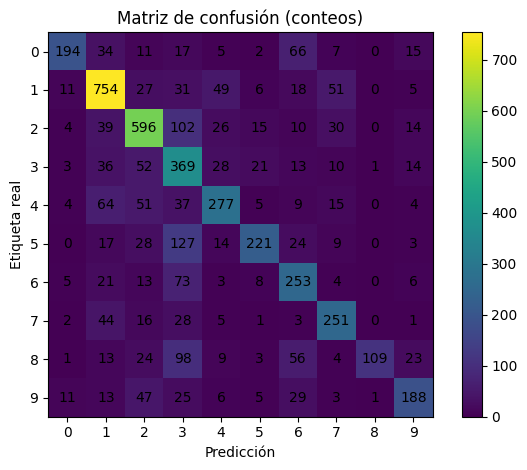

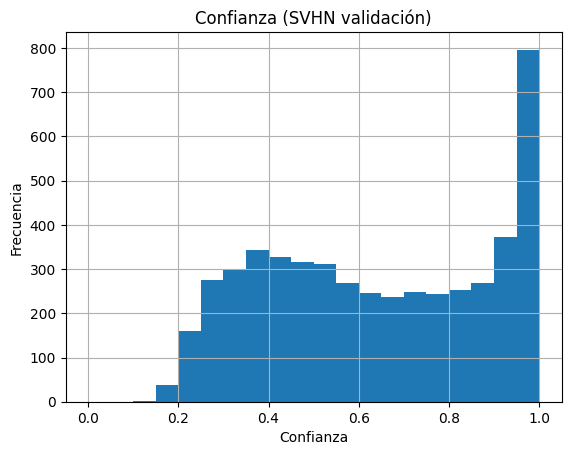

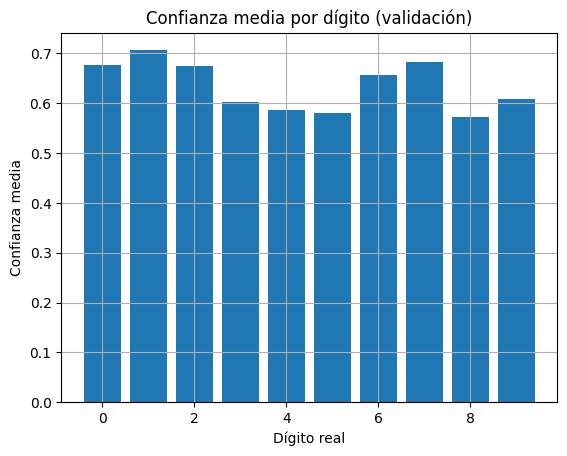

In [12]:
# ---- ENTRENAR o CARGAR ----
model, hist = train_or_load(
    epochs=8, batch=256, lr=2e-3,
    freeze_backbone=True, train_subset=30000, val_subset=10000,
    return_history=True
)

# ---- Curvas de entrenamiento ----
plot_training_curves(hist)

# ---- Matriz de confusión + versión normalizada ----
cm, conf_all = confusion_matrix_svhn(model, split="test", subset=5000, batch=512)
plot_confusion_matrix(cm, normalize=False,  title="Matriz de confusión (conteos)")

# ---- Confianza: histograma y confianza media por dígito ----
plot_confidence_hist(conf_all, title="Confianza (SVHN validación)")
plot_mean_conf_by_digit(model, split="test", subset=5000, batch=512)
